In [2]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from glob import glob
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
from torchvision import transforms

In [3]:
import os
import numpy as np
from glob import glob
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import DataLoader, TensorDataset
import cv2  # 确保导入 OpenCV
from PIL import Image

# 获取所有图像路径，递归查找
data = glob(r'/root/autodl-tmp/fingerprints/fingerprints/DB*/**/*.tif', recursive=True)
images = []

def readImages(data):
    for img_path in data:
        print(f"尝试读取图像: {img_path}")  # 打印图像路径
        
        # 使用 PIL 读取图像
        try:
            img = Image.open(img_path)
            img = img.convert("RGB")  # 确保图像为 RGB 格式
            img = img.resize((224, 224))  # 调整图像尺寸
            images.append(np.array(img))  # 转换为 numpy 数组并添加到列表中
        except Exception as e:
            print(f"无法读取图像: {img_path}，错误信息: {e}")
    
    return images


# 读取图像
images = readImages(data)

# 检查是否成功读取任何图像
if len(images) == 0:
    raise ValueError("没有成功读取任何图像，请检查文件路径和格式。")

# 将图像数据转换为 float32 类型，并归一化到 [0, 1] 之间
images_arr = np.asarray(images).astype('float32') / 255.0

# 检查图像形状
print("图像形状:", images_arr.shape)

# 将图像的通道数从 (N, 224, 224, 3) 转换为 (N, 3, 224, 224) (PyTorch 使用通道优先格式)
if len(images_arr.shape) == 4:
    images_arr = np.transpose(images_arr, (0, 3, 1, 2))
else:
    raise ValueError("图像数组的形状不正确，检查读取步骤。")

# 划分训练集和验证集
train_X, valid_X, train_ground, valid_ground = train_test_split(images_arr, images_arr, test_size=0.2, random_state=13)

# 将数据转换为 PyTorch 张量
train_X = torch.tensor(train_X, dtype=torch.float32)
valid_X = torch.tensor(valid_X, dtype=torch.float32)

train_ground = torch.tensor(train_ground, dtype=torch.float32)
valid_ground = torch.tensor(valid_ground, dtype=torch.float32)

# 创建 PyTorch 数据加载器
train_dataset = TensorDataset(train_X, train_ground)
valid_dataset = TensorDataset(valid_X, valid_ground)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=128, shuffle=False)


尝试读取图像: /root/autodl-tmp/fingerprints/fingerprints/DB1_B/108_6.tif
尝试读取图像: /root/autodl-tmp/fingerprints/fingerprints/DB1_B/101_1.tif
尝试读取图像: /root/autodl-tmp/fingerprints/fingerprints/DB1_B/108_7.tif
尝试读取图像: /root/autodl-tmp/fingerprints/fingerprints/DB1_B/101_2.tif
尝试读取图像: /root/autodl-tmp/fingerprints/fingerprints/DB1_B/108_8.tif
尝试读取图像: /root/autodl-tmp/fingerprints/fingerprints/DB1_B/101_3.tif
尝试读取图像: /root/autodl-tmp/fingerprints/fingerprints/DB1_B/109_1.tif
尝试读取图像: /root/autodl-tmp/fingerprints/fingerprints/DB1_B/101_4.tif
尝试读取图像: /root/autodl-tmp/fingerprints/fingerprints/DB1_B/109_3.tif
尝试读取图像: /root/autodl-tmp/fingerprints/fingerprints/DB1_B/101_5.tif
尝试读取图像: /root/autodl-tmp/fingerprints/fingerprints/DB1_B/109_2.tif
尝试读取图像: /root/autodl-tmp/fingerprints/fingerprints/DB1_B/101_6.tif
尝试读取图像: /root/autodl-tmp/fingerprints/fingerprints/DB1_B/109_4.tif
尝试读取图像: /root/autodl-tmp/fingerprints/fingerprints/DB1_B/101_7.tif
尝试读取图像: /root/autodl-tmp/fingerprints/fingerprints/DB1_B/109_5

In [4]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        
        # 编码器部分
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),  # 输入为 3 通道图像
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU()
        )
        
        # 解码器部分
        self.decoder = nn.Sequential(
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(64, 3, kernel_size=3, stride=1, padding=1),  # 输出为 3 通道图像
            nn.Sigmoid()  # 输出范围为 [0, 1]
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

# 实例化模型
autoencoder = Autoencoder()

# 使用 GPU（如果可用）
device = torch.device("cuda")  # 改为使用 CPU
autoencoder.to(device)


Autoencoder(
  (encoder): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
  )
  (decoder): Sequential(
    (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Upsample(scale_factor=2.0, mode='nearest')
    (3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): Upsample(scale_factor=2.0, mode='nearest')
    (6): Conv2d(64, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): Sigmoid()
  )
)

In [5]:
criterion = nn.MSELoss()  # 均方误差损失函数
optimizer = optim.RMSprop(autoencoder.parameters(), lr=0.001)  # 使用 RMSprop 优化器


In [6]:
# 训练模型的函数
def train_model(model, train_loader, valid_loader, criterion, optimizer, epochs=300):
    model.train()
    train_loss = []
    valid_loss = []
    
    for epoch in range(epochs):
        running_loss = 0.0
        for data in train_loader:
            inputs, targets = data
            inputs, targets = inputs.to(device), targets.to(device)
            
            # 前向传播
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            
            # 反向传播和优化
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
        
        # 计算训练集损失
        train_loss.append(running_loss / len(train_loader))
        
        # 计算验证集损失
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for data in valid_loader:
                inputs, targets = data
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                val_loss += loss.item()
        
        valid_loss.append(val_loss / len(valid_loader))
        
        print(f"Epoch {epoch+1}/{epochs}, Training Loss: {train_loss[-1]:.4f}, Validation Loss: {valid_loss[-1]:.4f}")
    
    return train_loss, valid_loss

# 训练模型
train_loss, valid_loss = train_model(autoencoder, train_loader, valid_loader, criterion, optimizer, epochs=300)


Epoch 1/300, Training Loss: 0.1511, Validation Loss: 0.2439
Epoch 2/300, Training Loss: 0.1461, Validation Loss: 0.0642
Epoch 3/300, Training Loss: 0.1072, Validation Loss: 0.0712
Epoch 4/300, Training Loss: 0.0691, Validation Loss: 0.0747
Epoch 5/300, Training Loss: 0.0691, Validation Loss: 0.0703
Epoch 6/300, Training Loss: 0.0643, Validation Loss: 0.0548
Epoch 7/300, Training Loss: 0.0963, Validation Loss: 0.0741
Epoch 8/300, Training Loss: 0.0688, Validation Loss: 0.0712
Epoch 9/300, Training Loss: 0.0658, Validation Loss: 0.0651
Epoch 10/300, Training Loss: 0.0571, Validation Loss: 0.0446
Epoch 11/300, Training Loss: 0.0670, Validation Loss: 0.1749
Epoch 12/300, Training Loss: 0.1123, Validation Loss: 0.0428
Epoch 13/300, Training Loss: 0.0404, Validation Loss: 0.0523
Epoch 14/300, Training Loss: 0.0417, Validation Loss: 0.0415
Epoch 15/300, Training Loss: 0.0343, Validation Loss: 0.0407
Epoch 16/300, Training Loss: 0.0336, Validation Loss: 0.0325
Epoch 17/300, Training Loss: 0.02

In [1]:
import pickle

# 指定损失数据文件的路径
loss_data_path = r'D:/PycharmProjects/保存的参数/指纹参数/loss_data(relu).pkl'

# 直接加载损失数据
with open(loss_data_path, 'rb') as f:
    loss_data = pickle.load(f)

# 获取训练和验证损失
train_loss = loss_data['train_loss']
valid_loss = loss_data['valid_loss']

print("损失数据已成功加载。")



损失数据已成功加载。


Failed to find a Ghostscript installation.  Distillation step skipped.


损失图已保存到 D:\PycharmProjects\保存的参数\指纹参数\loss_relu.eps


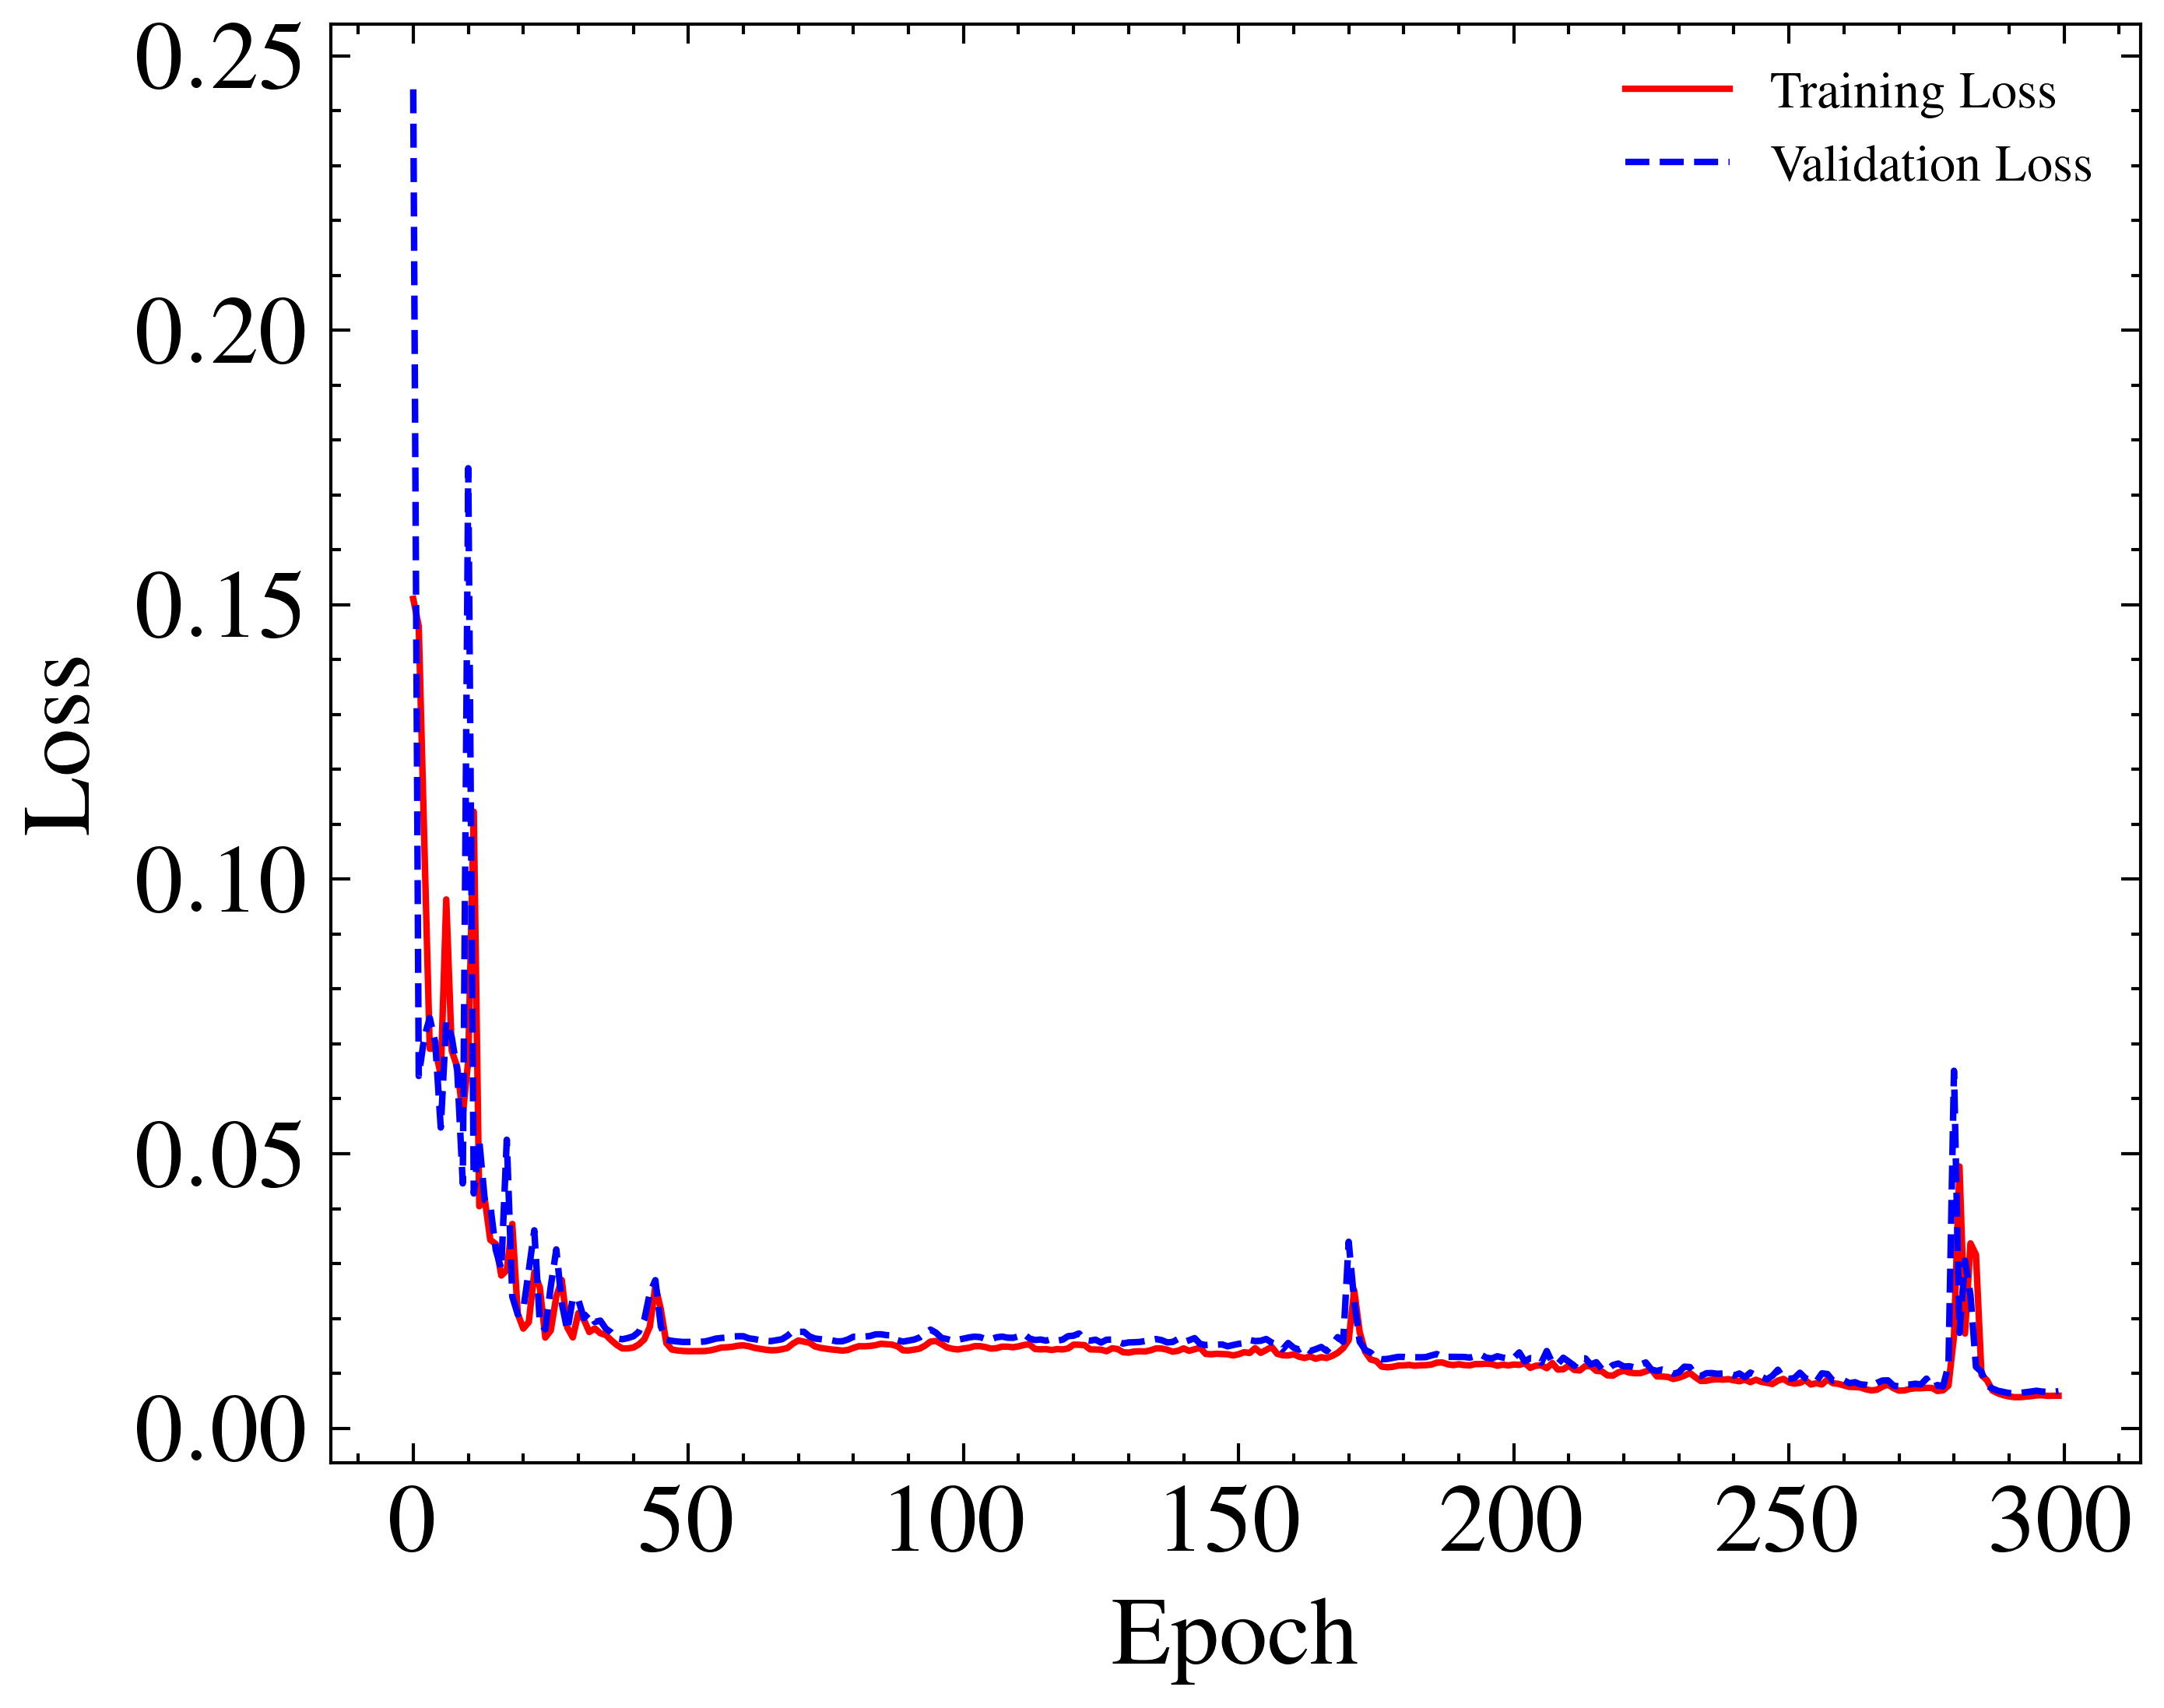

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import scienceplots

# 配置绘图样式和参数
plt.rcParams['font.serif'] = ['Times New Roman']
mpl.rcParams['figure.dpi'] = 800
mpl.rcParams['axes.unicode_minus'] = True
plt.style.use(['science', 'ieee'])
plt.rcParams['text.usetex'] = True

# 创建图形和坐标轴
fig, ax = plt.subplots(figsize=(5, 4))
plt.cla()  # 清除现有内容
plt.tick_params(labelsize=15)  # 设置刻度字体大小

# 绘制损失曲线（红色和蓝色）
ax.plot(np.arange(len(train_loss)), train_loss, color='red', label='Training Loss', linewidth=1)
ax.plot(np.arange(len(valid_loss)), valid_loss, color='blue', label='Validation Loss', linewidth=1)

# 设置正体的轴标签
ax.set_xlabel(r'$\mathrm{Epoch}$', fontsize=15)
ax.set_ylabel(r'$\mathrm{Loss}$', fontsize=15)

# 手动设置x轴刻度
plt.xticks(np.arange(0, len(train_loss) + 5, step=50))

# 添加图例（标注）
plt.legend(fontsize=8, loc='upper right')

# 指定保存路径和文件名
plot_path = r'D:\PycharmProjects\保存的参数\指纹参数\loss_relu.eps'

# 保存为 EPS 文件
plt.savefig(plot_path, format='eps', bbox_inches='tight')
print(f"损失图已保存到 {plot_path}")

# 展示损失图
plt.show()


所有图像已保存至: ./reluPics/


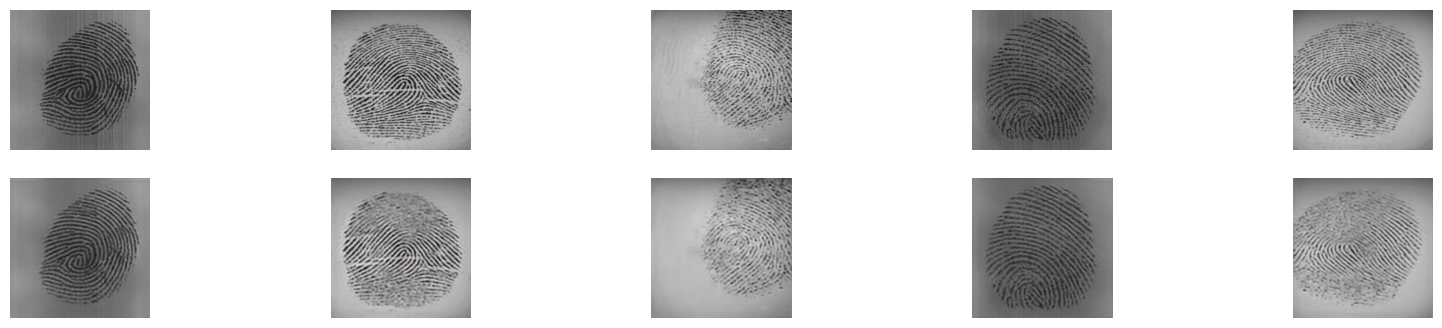

In [8]:
import os
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

def save_and_visualize_reconstructions(model, data_loader, save_dir):
    """
    将所有验证集图像的原始和重建图像保存到指定文件夹，并展示前 5 张的对比。
    参数：
    - model: Autoencoder 模型
    - data_loader: 验证集的数据加载器
    - save_dir: 保存图像的文件夹路径（你需要提前创建好）
    """
    # 切换到评估模式
    model.eval()
    os.makedirs(save_dir, exist_ok=True)  # 如果文件夹不存在则创建
    img_counter = 0  # 图像计数器

    with torch.no_grad():
        # 遍历验证集批次
        for inputs, _ in data_loader:
            inputs = inputs.to(device)
            outputs = model(inputs)

            # 将张量转换为 NumPy 格式，并缩放到 [0, 255]
            inputs = (inputs.cpu().numpy() * 255).astype(np.uint8)
            outputs = (outputs.cpu().numpy() * 255).astype(np.uint8)

            # 遍历批次中的每一张图像
            for i in range(inputs.shape[0]):
                # 转换为 (H, W, C) 格式（适用于 PIL）
                original_img = np.transpose(inputs[i], (1, 2, 0))
                reconstructed_img = np.transpose(outputs[i], (1, 2, 0))

                # 保存原始和重建图像
                original_path = os.path.join(save_dir, f"original_{img_counter}.png")
                reconstructed_path = os.path.join(save_dir, f"reconstructed_{img_counter}.png")
                
                Image.fromarray(original_img).save(original_path)
                Image.fromarray(reconstructed_img).save(reconstructed_path)

                img_counter += 1  # 更新计数器

    print(f"所有图像已保存至: {save_dir}")

    # 展示前 5 张原始和重建图像的对比
    plt.figure(figsize=(20, 4))
    for i in range(5):
        # 加载已保存的图像
        original_img = Image.open(os.path.join(save_dir, f"original_{i}.png"))
        reconstructed_img = Image.open(os.path.join(save_dir, f"reconstructed_{i}.png"))

        # 显示原始图像
        plt.subplot(2, 5, i + 1)
        plt.imshow(original_img)
        plt.axis('off')

        # 显示重建图像
        plt.subplot(2, 5, i + 6)
        plt.imshow(reconstructed_img)
        plt.axis('off')

    plt.show()

# 使用你指定的文件夹路径保存和展示重建图像
save_dir = "./reluPics/" # 将此处替换为你创建的文件夹路径
save_and_visualize_reconstructions(autoencoder, valid_loader, save_dir)

In [9]:
import shutil

# 指定要压缩的文件夹和输出路径
folder_to_zip = "./reluPics"  # 已存在的文件夹路径
zip_output_path = "./reluPics.zip"  # 输出的 ZIP 文件路径

# 压缩文件夹
shutil.make_archive(zip_output_path.replace('.zip', ''), 'zip', folder_to_zip)

print(f"文件夹已成功压缩为: {zip_output_path}")


文件夹已成功压缩为: ./reluPics.zip
